In [3]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8
import decord
from decord import cpu, gpu
import numpy as np
import torchvision.transforms as T
import ast
from lavis.models import load_model_and_preprocess

2023-12-05 23:19:56.317641: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 23:19:56.317712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 23:19:56.319208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 23:19:56.327649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 23:19:57.825252: W tensorflow/comp

In [1]:
import torch

In [21]:
with torch.cuda.device(torch.device('cuda:0')): 
    info = torch.cuda.mem_get_info()
print(info[0] / info[1])


0.019963964708129625


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device, device2)

cuda:0 cuda:1


In [3]:
import utils

cuda:3 cuda:4


In [23]:
torch.cuda.mem_get_info(9)

(11381768192, 11546394624)

In [4]:
def get_video(video_path, fps=30):
        # If fixed width and height are required, VideoReader takes width and height as arguments.
        video_reader = decord.VideoReader(str(video_path), num_threads=1, ctx=cpu(0))
        decord.bridge.set_bridge('torch')
        vlen = len(video_reader)
        print(vlen)
        original_fps = video_reader.get_avg_fps()
        print(original_fps)
        num_frames = int(vlen * fps / original_fps)
        # num_frames = min(self.max_num_frames, num_frames)
        frame_idxs = np.linspace(0, vlen, num_frames, endpoint=False).astype(np.int_)
        video = video_reader.get_batch(frame_idxs).byte()
        video = video.permute(0, 3, 1, 2)
        return video

In [5]:
video_id = 3489439407
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')
video.shape

1662
29.97002997002997


torch.Size([1663, 3, 480, 640])

In [6]:

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["lady in blue standing listening to her headphones"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

KeyboardInterrupt: 

75/270


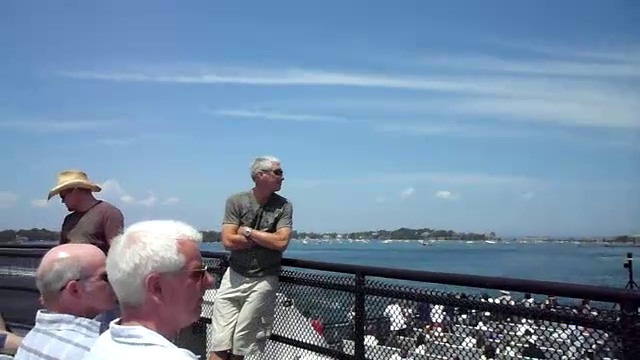

In [109]:
raw_image = images[indices[0][0].item() - 150]
print(f"{indices[0][0].item()}/{len(images)}")
raw_image

In [26]:
from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
# preprocess the image
# vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
# generate caption
model.generate({"image": image})
# ['a large fountain spewing water into the air']

NameError: name 'raw_image' is not defined

In [9]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device2)
# ask a random question.
question = "What is the man doing in the video?"
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
question = txt_processors["eval"](question)
model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")

NameError: name 'load_model_and_preprocess' is not defined

In [10]:
import openai

with open('api.key') as f:
    openai.api_key = f.read().strip()
with open('api_org.key') as f:
    openai.organization = f.read().strip()

def call_llm(prompt):
    completion = openai.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "Follow the directions given in the next prompt carefully."},
        {"role": "user", "content": prompt}
      ]
    )
    output_message = completion.choices[0].message.content
    return output_message


In [42]:
def get_answer_helper(question, answer_choices, curr_frame, total_frames, caption, prev_info=None):
    with open('./prompts/base_prompt.txt') as f:
        prompt = f.read()
    prompt = prompt.replace('insert_question', question)
    prompt = prompt.replace('insert_choices', str(answer_choices))
    prompt = prompt.replace('insert_curr_frame', str(curr_frame))
    prompt = prompt.replace('insert_total_frames', str(total_frames))
    prompt = prompt.replace('insert_caption', caption[0])

    #print(prompt)
    output = call_llm(prompt)
    try:
        output_dict = ast.literal_eval(output)
        print("GETTING OUTPUT: ", output_dict)
        return output_dict
    except:
        print("ERROR: ", output)

In [49]:
def final_select(question, choices, info):
    with open('./prompts/final_prompt.txt') as f:
        prompt = f.read()
    prompt = prompt.replace('insert_question', question)
    prompt = prompt.replace('insert_choices', str(choices))
    prompt = prompt.replace('insert_info', str(info))
    #print(prompt)
    output = call_llm(prompt)
    try:
        output_dict = ast.literal_eval(output)
        print("GETTING OUTPUT: ", output_dict)
        return output_dict
    except:
        print("ERROR: ", output)

In [13]:
def query_VQA(vqa_question, frame):
    print("CALLING VQA: ", vqa_question)
    model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device2)
    # ask a random question.
    question = vqa_question
    image = vis_processors["eval"](frame).unsqueeze(0).to(device2)
    question = txt_processors["eval"](question)
    answer = model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")
    print("VQA ANSWER: ", answer)
    return answer

In [14]:
def query_caption(frame):
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](frame).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    return caption

In [32]:
def get_answer(images, question, answer_choices, curr_frame, total_frames, caption, prev_info=None):
    LIMIT = 10
    goto_frame = curr_frame
    VQA_question = None
    info = {}
    caption = caption
    while LIMIT >= 0:
        print(f"CALL {10 - LIMIT}")
        print("ALL INFO:", info)
        if f"Frame {goto_frame}" not in info:
            info[f"Frame {goto_frame}"] = {}
        LIMIT -= 1  
        if goto_frame != None:
            raw_image = images[goto_frame] 
        caption = query_caption(raw_image)
        print(caption)
        output = get_answer_helper(question, answer_choices, goto_frame, total_frames, caption, prev_info)
        print(output)
        if output["Answer"] != None:
            print("here1")
            return output["Answer"]
        else:
            info[f"Frame {goto_frame}"]["caption"] = caption
            if output["Choose Frame"] != None:
                goto_frame = output["Choose Frame"]
            if output["VQA Question"] != None:
                VQA_question = output["VQA Question"]
                vqa_result = query_VQA(VQA_question, raw_image)
                info[f"Frame {curr_frame}"][VQA_question] = vqa_result
            else:
                continue       
    # case for when we run out of tries
    final_output = final_select(question, answer_choices, info)
    return final_output

In [33]:
def answer_question(vid_id, quest, option_choices, query):
    video_id = vid_id
    question = quest
    options = option_choices
    video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

    model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    model = model.to(device)
    preprocess = preprocess
    tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

    transform = T.ToPILImage()
    sampling_rate = 10
    images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

    labels_list = query
    image_stack = torch.stack([preprocess(image) for image in images]).to(device)
    text = tokenizer(labels_list, context_length=model.context_length).to(device)


    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image_stack)
        text_features = model.encode_text(text)
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

        text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

    values, indices = torch.topk(text_probs, 3)

    raw_image = images[indices[0][0].item()]
    print(f"{indices[0][0].item()}/{len(images)}")

    from lavis.models import load_model_and_preprocess
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    print(caption)
    raw_image.show()
    result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
    return result

In [34]:
def answer_question_half(vid_id, quest, option_choices, query):
    video_id = vid_id
    question = quest
    options = option_choices
    video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

    model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    model = model.to(device)
    preprocess = preprocess
    tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

    transform = T.ToPILImage()
    sampling_rate = 10
    images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

    labels_list = query
    image_stack = torch.stack([preprocess(image) for image in images]).to(device)
    text = tokenizer(labels_list, context_length=model.context_length).to(device)


    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image_stack)
        text_features = model.encode_text(text)
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

        text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

    values, indices = torch.topk(text_probs, 3)

    raw_image = images[indices[0][0].item()]
    print(f"{indices[0][0].item()}/{len(images)}")

    from lavis.models import load_model_and_preprocess
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    print(caption)
    raw_image.show()
    return images, caption
    #result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
    #return result

# Q1

In [50]:
video_id = 5907839036
question = "where is this happening?"
options = ['bridge', 'trail', 'skate park', 'house', 'bed room']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["lady in blue standing listening to her headphones"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

raw_image = images[indices[0][0].item() - 150]
print(f"{indices[0][0].item()}/{images.shape[0]}")

from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
caption = model.generate({"image": image})
print(caption)
raw_image

2697
29.97002997002997


KeyboardInterrupt: 

In [146]:
result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
result

{'Enough Information?': True, 'Answer': 0, 'Choose Frame': None, 'VQA Question': None}


0

# Q2

369
29.97002997002997


3/37
['a group of young men playing guitars on stage']


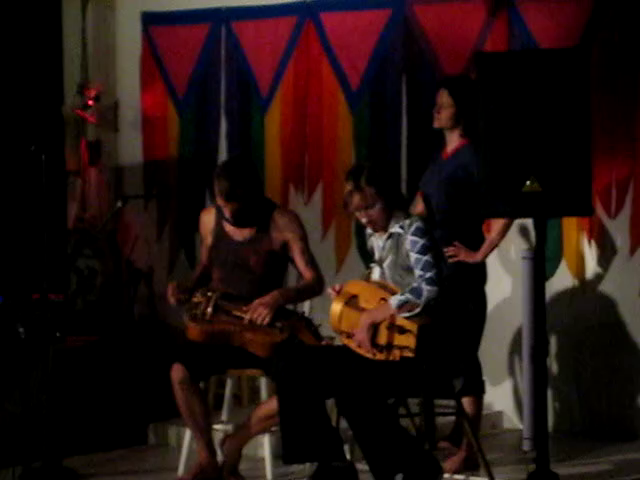

In [21]:
video_id = 4010069381
question = "why does the lady walks away after the conversation with man is over?"
options = ['pick up phone', 'enjoying stroll', 'giving her space to perform', 'help man do something else', 'performance ended']

images, caption = answer_question_half(video_id, question, options, "lady walking away")

In [24]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

CALL 0
ALL INFO: {}
['a group of young men playing guitars on stage']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 20, 'VQA Question': 'What is the man in the video doing?'}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 20, 'VQA Question': 'What is the man in the video doing?'}
CALLING VQA:  What is the man in the video doing?
VQA ANSWER:  ['playing guitar']
CALL 1
ALL INFO: {'Frame 3': {'caption': ['a group of young men playing guitars on stage'], 'What is the man in the video doing?': ['playing guitar']}}
['a group of people playing instruments in a room']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': None, 'VQA Question': 'What is happening in the video?'}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': None, 'VQA Question': 'What is happening in the video?'}
CALLING VQA:  What is happening in the video?
VQA ANSWER:  ['playing music']
CALL 2
ALL INFO: {'Frame 3': {'caption': ['a grou

2

# Q3

2697
29.97002997002997
2697
29.97002997002997
37/270
['a view of a harbor with a boat in the water']


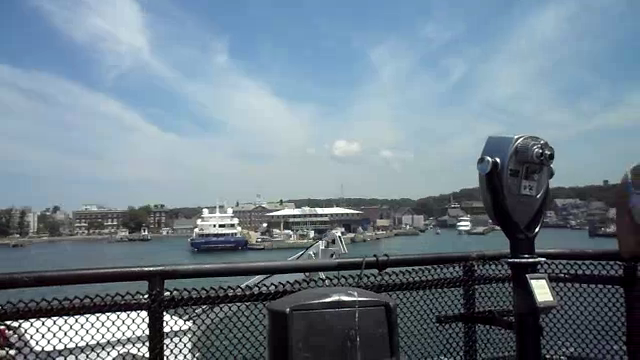

In [25]:
video_id = 5907839036
question = "where is this happening?"
options = ['bridge', 'trail', 'skate park', 'house', 'bed room']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "location of the image")

In [75]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

CALL 0
ALL INFO: {}
['a man standing next to a large body of water']
GETTING OUTPUT:  {'Enough Information?': True, 'Answer': 0, 'Choose Frame': None, 'VQA Question': None}
{'Enough Information?': True, 'Answer': 0, 'Choose Frame': None, 'VQA Question': None}
here1


0

# Q4

1662
29.97002997002997
1662
29.97002997002997
133/167
['a woman with headphones on in a recording studio']


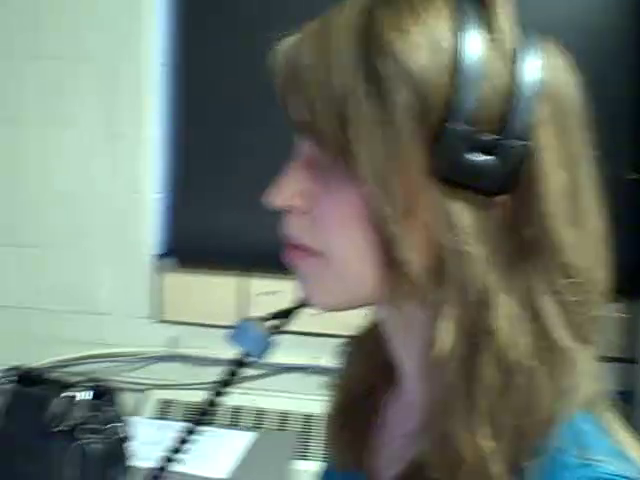

In [26]:
video_id = 3489439407
question = "what are the two men doing as the lady in blue stands and listen via her headphone?"
options = ['turns around', 'working on the radio', 'moving the papers', 'walk forward', 'choosing a flower']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "lady in blue standing listening to her headphones")

In [27]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

CALL 0
ALL INFO: {}


['a man and a woman in a recording studio']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 3, 'VQA Question': 'What is the lady in blue doing?'}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 3, 'VQA Question': 'What is the lady in blue doing?'}
CALLING VQA:  What is the lady in blue doing?
VQA ANSWER:  ['listening to music']
CALL 1
ALL INFO: {'Frame 3': {'caption': ['a man and a woman in a recording studio'], 'What is the lady in blue doing?': ['listening to music']}}
['a man and a woman in a recording studio']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 30, 'VQA Question': None}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 30, 'VQA Question': None}
CALL 2
ALL INFO: {'Frame 3': {'caption': ['a man and a woman in a recording studio'], 'What is the lady in blue doing?': ['listening to music']}}
['a man and a woman are looking at a video game']
GETTING OUTPUT:  {'Enough Information?': F

1

# Q4

453
29.97002997002997
453
29.97002997002997
1/46
['a group of people standing in a living room']


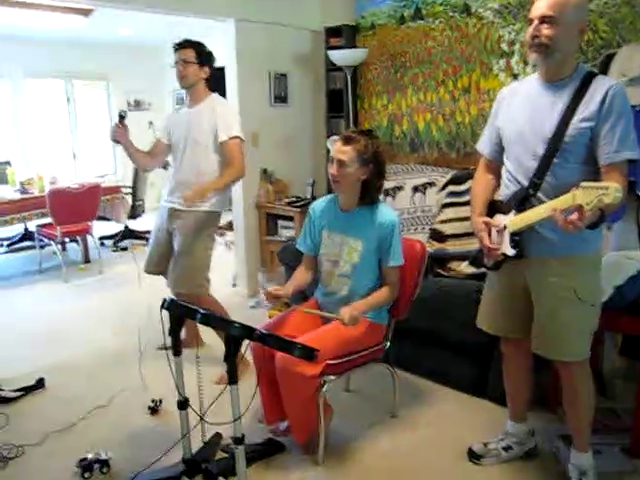

In [28]:
video_id = 3814690167
question = "why did the man in glasses bounce up and down at the start of the video?"
options = ['warm up', 'supportive audience', 'clap to the beats', 'to show his passion for dancing', 'begin to sing']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "man in glasses bouncing up and down")

In [79]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

CALL 0
ALL INFO: {}
['a group of people in a room with a guitar']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': -2, 'VQA Question': 'What is the man in glasses doing at the start of the video?'}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': -2, 'VQA Question': 'What is the man in glasses doing at the start of the video?'}
CALLING VQA:  What is the man in glasses doing at the start of the video?
VQA ANSWER:  ['playing guitar']
CALL 1
ALL INFO: {'Frame 3': {'caption': ['a group of people in a room with a guitar'], 'What is the man in glasses doing at the start of the video?': ['playing guitar']}}
['a group of people standing in a living room']
GETTING OUTPUT:  {'Enough Information?': False, 'Answer': None, 'Choose Frame': 2, 'VQA Question': None}
{'Enough Information?': False, 'Answer': None, 'Choose Frame': 2, 'VQA Question': None}
CALL 2
ALL INFO: {'Frame 3': {'caption': ['a group of people in a room with a guitar'], 'What is the man i

0

# Q5

1721
29.97
1721
29.97
31/173
['a boy and a girl sitting on a couch']


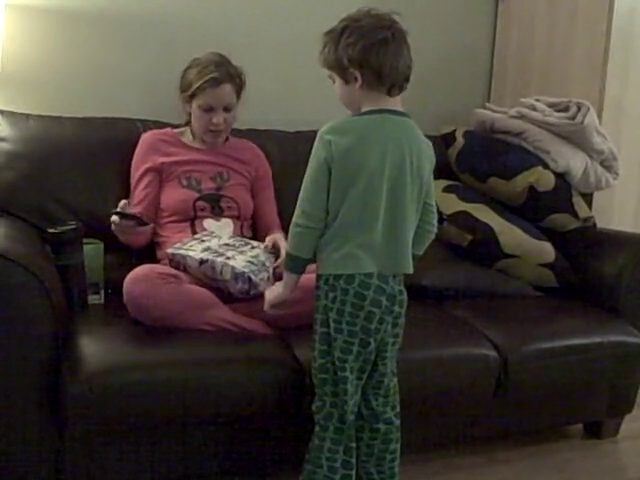

In [54]:
video_id = 11566980553
question = "how does the woman respond after the boy gives her the present?"
options = ['smile', 'puts present aside and ignore him', 'write something down', 'cry', 'walk back to the man']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "woman recieving present from boy")

In [51]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

CALL 0
ALL INFO: {}
['a young boy standing in a living room holding a nintendo wii controller']
GETTING OUTPUT:  {'Enough Information?': True, 'Answer': 3, 'Choose Frame': None, 'VQA Question': None}
{'Enough Information?': True, 'Answer': 3, 'Choose Frame': None, 'VQA Question': None}
here1


3

In [55]:
final_select(question, options, {'Frame 3': {'caption': ['a young boy standing in a living room holding a nintendo wii controller'], 'What does the man do after the boy gives the present?': ['play wii'], "What is the woman's reaction to the boy's present?": ['happy'], "What is the woman's reaction to the boy's gift?": ['happy'], 'What is the woman doing in the video?': ['eating'], 'What are the kids doing on top of the couch?': ['playing'], 'What is happening in the video?': ['playing wii']}, 'Frame 150': {'caption': ['a young boy sitting on the floor reading a book']}, 'Frame 30': {'caption': ['a couple of kids sitting on top of a couch']}, 'Frame 133': {'caption': ['a young boy sitting on the floor holding a wii remote']}})

ERROR:  To answer the question, "how does the woman respond after the boy gives her the present?", we need to analyze the available information.

We have several frames with their respective captions and question-answer pairs. We need to find the frame that contains information about the woman's response. 

We can ignore frames that do not mention the woman's reaction or the present. It seems that frames 3, 150, and 133 may contain relevant information.

Frame 3:
- Caption: "a young boy standing in a living room holding a nintendo wii controller"
- Question: "What is the woman's reaction to the boy's present?"
- Answer: "happy"

Frame 150:
- Caption: "a young boy sitting on the floor reading a book"

Frame 30:
- Caption: "a couple of kids sitting on top of a couch"

Frame 133:
- Caption: "a young boy sitting on the floor holding a wii remote"

Based on the available information, it seems that only Frame 3 provides relevant information about the woman's reaction. The answer in Frame 3 s

In [37]:
"['smile', 'puts present aside and ignore him', 'write something down', 'cry', 'walk back to the man']",,how does the woman respond after the boy gives her the present?,1,11566980553.mp4

SyntaxError: invalid decimal literal (3670382466.py, line 1)

- Image level allows you to go back and forth in time, can't do in video-models
    - Binary search aspect -> start in middle -> move forward if not
    - Exponential or recursive
- Image level leveraging for video -> algorithm efficiency analysis
- Show that it works for multiple datasets
- List of different datasets other than NextQA

In [1]:
import dataset

In [2]:
dataset.get_data("queries_2k.csv")

['index', 'sample_id', 'possible_answers', 'query_type', 'query', 'answer', 'video_name']
['0', '4377', "['frown', 'curious', 'look at lights', 'dances', 'try to turn around']", '', 'what does the baby do after he lights up the toy?', '2', '3471421544.mp4']
['0', '3042', "['to reverse', 'it comes as a set', 'performing at an event', 'keep baby from falling', 'wants lady to help her hold']", '', 'why does the girl hold the stick whenever she is playing with the toy?', '1', '11966080214.mp4']
['0', '2845', "['wind blowing', 'pulled by girl', 'lady pushes it', 'he was moving in it', 'remote controlled']", '', 'why was the baby s chair rocking?', '3', '9088819598.mp4']
['0', '2570', "['fly', 'walks away', 'runs away', 'someone carried the bird', 'jump down']", '', 'how did the black bird move away from the pot towards the end of video?', '0', '5833145209.mp4']
['0', '4825', "['try to stand up', 'playing with dog', 'getting caught', 'playing with it', 'stuck at sofa']", '', 'why did the chi

(['sample_id',
  '4377',
  '3042',
  '2845',
  '2570',
  '4825',
  '1215',
  '4823',
  '442',
  '4432',
  '573',
  '3823',
  '699',
  '1277',
  '779',
  '4962',
  '4241',
  '2086',
  '1210',
  '886',
  '183',
  '3033',
  '3659',
  '2316',
  '1026',
  '4468',
  '32',
  '2622',
  '3577',
  '483',
  '4287',
  '3217',
  '3368',
  '3459',
  '4514',
  '2769',
  '3790',
  '1773',
  '1820',
  '356',
  '1027',
  '457',
  '1836',
  '902',
  '4566',
  '1519',
  '4800',
  '4030',
  '3982',
  '304',
  '3542',
  '634',
  '2024',
  '4523',
  '4530',
  '3322',
  '4495',
  '233',
  '1221',
  '3369',
  '3312',
  '1182',
  '1254',
  '2835',
  '835',
  '4191',
  '2773',
  '2681',
  '4014',
  '368',
  '2593',
  '4379',
  '1442',
  '2226',
  '412',
  '1585',
  '3857',
  '1973',
  '3756',
  '4446',
  '533',
  '1568',
  '3522',
  '4482',
  '2029',
  '1527',
  '1432',
  '1863',
  '4971',
  '1101',
  '3021',
  '168',
  '103',
  '2106',
  '2078',
  '487',
  '1690',
  '1423',
  '4966',
  '1408',
  '4167',
  '2629